# FastSMC example notebook

This notebook demonstrates how to use the FastSMC python bindings.

Please make sure you have installed the python bindings by following the instructions in `../README.md` before attempting to run this notebook.

1. import the necessary modules, including from `asmc` which is installed with the Python bindings

In [1]:
import os
import numpy as np
import pandas as pd

from asmc import (
    HMM,
    DecodingQuantities,
    DecodingParams,
    Data,
    DecodingMode,
    FastSMC,
)

2. Find the example data provided with ASMC that we will use for this notebook

In [2]:
# Get the ASMC directory and check we're in the expected place
base_dir = os.path.abspath('..')
assert 'FILES' in os.listdir(base_dir)
assert 'README.md' in os.listdir(base_dir)

file_dir = os.path.join(base_dir, 'FILES', 'FASTSMC_EXAMPLE')
name_prefix = 'out.25.n300.chr2.len30.dens1.disc10-20-2000.demoCEU.mapnorm.array'
decoding_quantities_file = os.path.join(file_dir, f'{name_prefix}.decodingQuantities.gz')
assert os.path.isfile(decoding_quantities_file)

# Ouput files will be generated alongside this notebook in a directory named 'tmp_output'
output_dir = os.path.join(base_dir, 'notebooks', 'tmp_output')
os.makedirs(output_dir, exist_ok=True)
assert(os.path.isdir(output_dir))

3. Set the required parameters

In [3]:
params = DecodingParams()
params.decodingQuantFile = decoding_quantities_file
params.inFileRoot = os.path.join(file_dir, name_prefix)
params.outFileRoot = os.path.join(output_dir, 'fastsmc_output')
params.decodingModeString = 'array'
params.decodingMode = DecodingMode.arrayFolded
params.foldData = True
params.usingCSFS = True
params.batchSize = 32
params.recallThreshold = 3
params.min_m = 1.5
params.GERMLINE = True
params.FastSMC = True
params.BIN_OUT = False
params.time = 50
params.noConditionalAgeEstimates = True
params.doPerPairMAP = True
params.doPerPairPosteriorMean = True
params.jobs = 4

4. Create the Python ASMC objects and run all four jobs.  This will probably take around 5-10 minutes on a laptop.

In [4]:
decoding_quantities = DecodingQuantities(params.decodingQuantFile)
sequence_length = Data.countHapLines(params.inFileRoot)

use_known_seed = False
use_batches = not params.noBatches
scaling_skip = 1

for job_ind in range(params.jobs):
    params.jobInd = 1 + job_ind   # params.jobInd is from 1...N
    data = Data(params.inFileRoot, sequence_length, decoding_quantities.CSFSSamples,
                params.foldData, params.usingCSFS, params.jobInd, params.jobs, use_known_seed)

    hmm = HMM(data, decoding_quantities, params, use_batches, 1)

    fast_smc = FastSMC()
    fast_smc.run(params, data, hmm)

5. Concatenate data

In [5]:
for job_ind in range(params.jobs):
    assert os.path.isfile(f'{params.outFileRoot}.{1 + job_ind}.{params.jobs}.FastSMC.ibd.gz')

frames = [pd.read_csv(f'{params.outFileRoot}.{x}.{params.jobs}.FastSMC.ibd.gz', sep='\t', header=None)
          for x in range(1, params.jobs + 1)]

all_data = pd.concat(frames)

col_names = ['ind1_famid', 'ind1_id', 'ind1_hap', 'ind2_famid', 'ind2_id', 'ind2_hap',
             'chromosome', 'ibd_start', 'ibd_end', 'ibd_score', 'map_est', 'post_est']

all_data.columns = col_names

all_data.insert(9, 'ibd_length', all_data['ibd_end'] - all_data['ibd_start'])
all_data

,ind1_famid,ind1_id,ind1_hap,ind2_famid,ind2_id,ind2_hap,chromosome,ibd_start,ibd_end,ibd_length,ibd_score,map_est,post_est
0,1_5,1_5,1,1_10,1_10,1,1,1575555,1608858,33303,0.002602,9079.879883,74.999878
1,1_5,1_5,1,1_10,1_10,1,1,1613357,2274988,661631,0.017505,1761.868164,94.999847
2,1_5,1_5,1,1_10,1_10,1,1,2288676,2312048,23372,0.002258,7347.246094,74.999878
3,1_9,1_9,2,1_55,1_55,1,1,936839,940357,3518,0.020423,19130.046875,54.999901
4,1_9,1_9,2,1_55,1_55,1,1,949094,2274988,1325894,0.160964,462.804382,54.999901
...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,1_114,1_114,1,1_116,1_116,1,1,29360442,29381648,21206,0.143284,9532.596680,14.999936
483,1_114,1_114,1,1_116,1_116,1,1,29720657,29849472,128815,0.000594,1793.918579,254.999725
484,1_118,1_118,1,1_148,1_148,1,1,28719020,28722890,3870,0.001855,11115.988281,24.999928
485,1_118,1_118,1,1_148,1_148,1,1,28747400,29849472,1102072,0.312458,172.659943,34.999920


6. Visualise data: here we simply bin the posterior age estimates of the IBD segments

<AxesSubplot:>

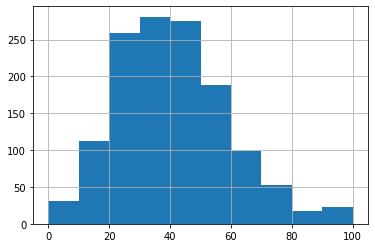

In [6]:
all_data['post_est'].hist(range=[0, 100])

<AxesSubplot:>

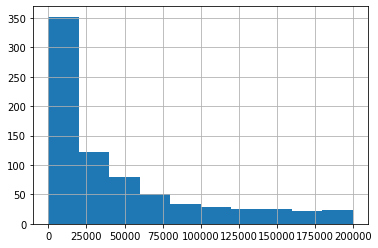

In [7]:
all_data['ibd_length'].hist(range=[1, 200000])